# Camera calibration

### Computing camera callibration coefficients and matrix, using the given images 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

#these are 9X6 calibration images
nx=9
ny=6

images = glob.glob('camera_cal/calibration*.jpg')
print('no. of images:', len(images))

#arrays for object points and image points
objpoints = []
imgpoints = []

#one time preparation of object points like (0,0,0) (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

for imgf in images:
    img = cv2.imread(imgf)
    
    #convert to gray scale. 
    #Note: Since used BGR
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        #this appends the same thing repeatedly, as they are mainly corner positions
        objpoints.append(objp)
        
#get the camera calibration matriz and coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


no. of images: 20


### Sample distorted image

size: (720, 1280, 3)


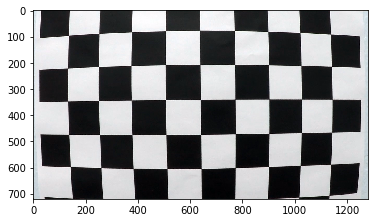

In [2]:
img1 = cv2.imread('camera_cal/calibration1.jpg')
print('size:', img1.shape)
plt.imshow(img1)
plt.show()

### Undistorted image

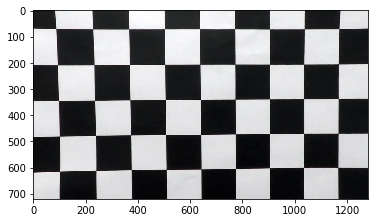

In [3]:
def undistort(img):
    undis = cv2.undistort(img, mtx, dist, None, mtx)
    return undis

udst1=undistort(img1)
plt.imshow(udst1)
plt.show()

# Pipeline (test images)

### Undistort

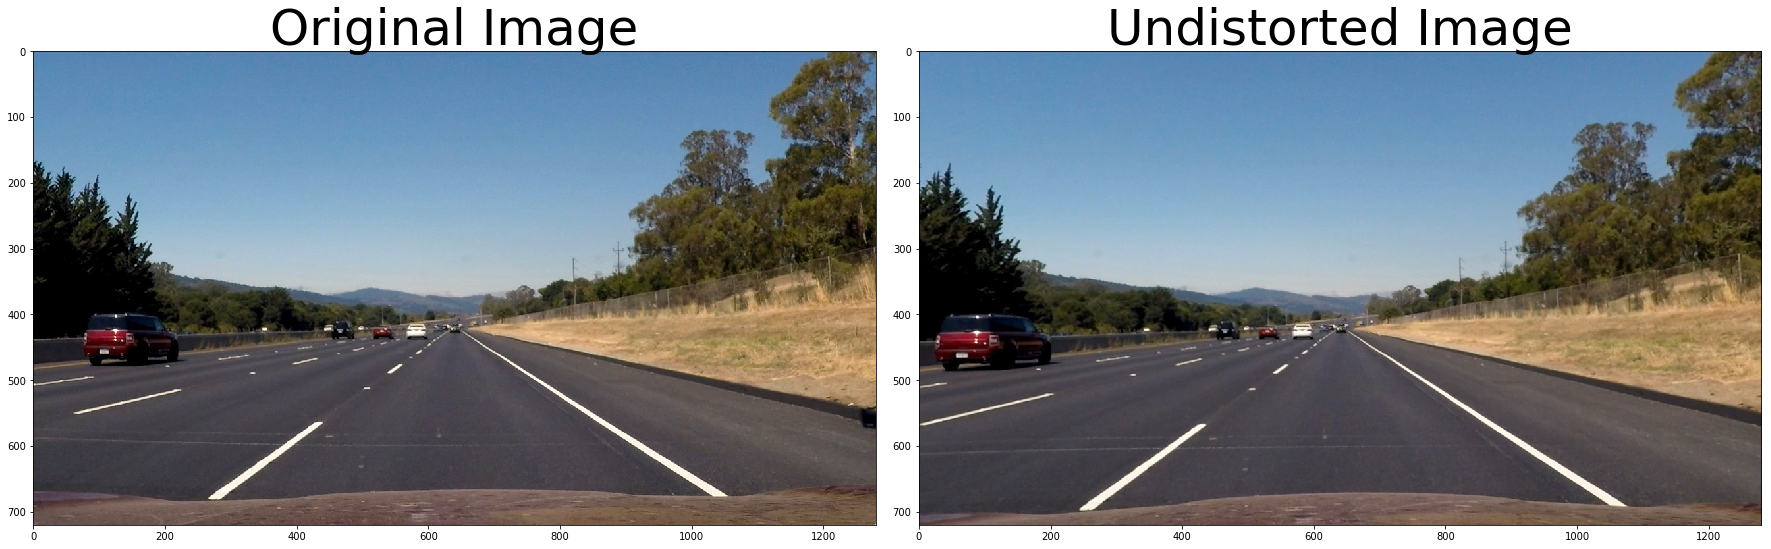

In [4]:
ex1 = cv2.imread('test_images/straight_lines2.jpg')
uex1 = undistort(ex1)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ex1RGB = cv2.cvtColor(ex1, cv2.COLOR_BGR2RGB)
#need to convert to rgb before plotting, so as to see the image in true colors
ax1.imshow(ex1RGB)
ax1.set_title('Original Image', fontsize=50)
#same for undistorted image. Convert to RGB before seeing
uex1RGB = cv2.cvtColor(uex1, cv2.COLOR_BGR2RGB)
ax2.imshow(uex1RGB)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0)
plt.show()

### Gradient threshold(Using Sobel)

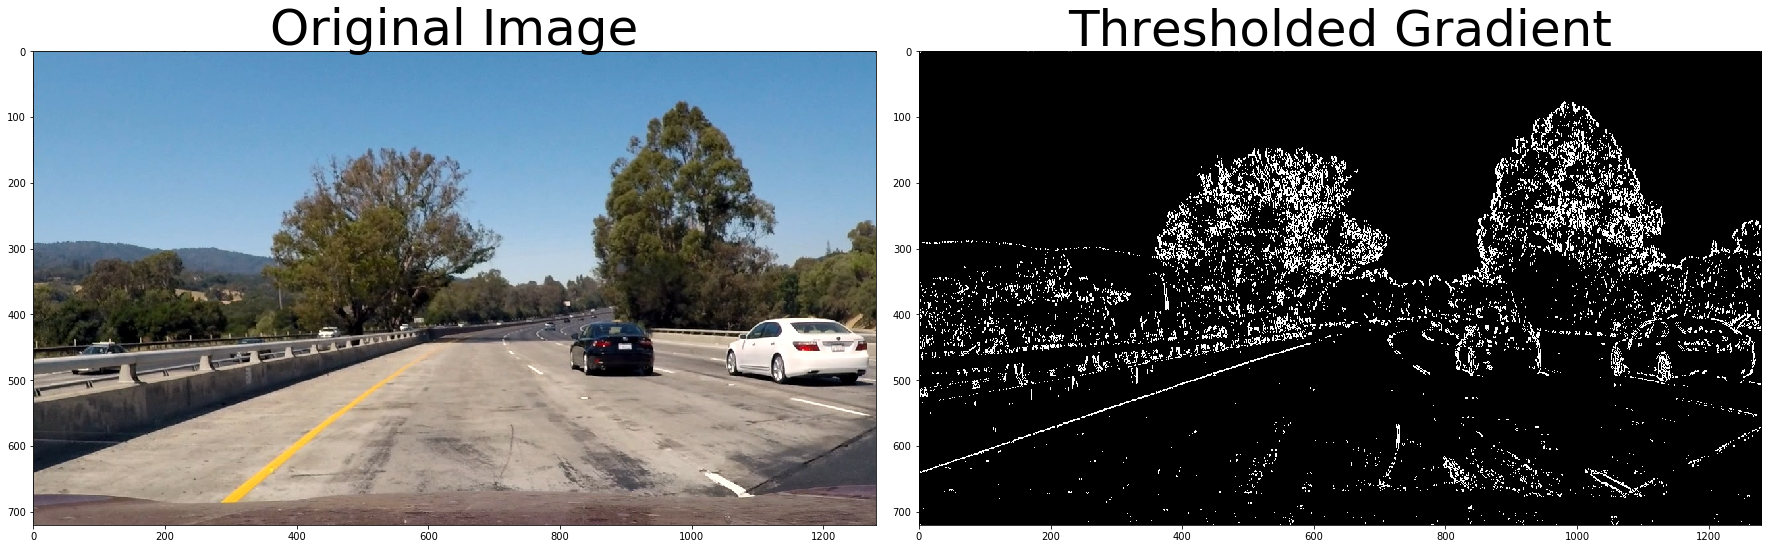

In [53]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    dx=0
    dy=0
    if orient == 'x':
        dx=1
    else:
        dy=1
        
    # 3) Take the absolute value of the derivative or gradient
    sobelxy = cv2.Sobel(gray, cv2.CV_64F, dx, dy)
    
    #important to look at only the absolute values (so even -ves become +ves)
    abs_sobel = np.absolute(sobelxy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### HSL threshold

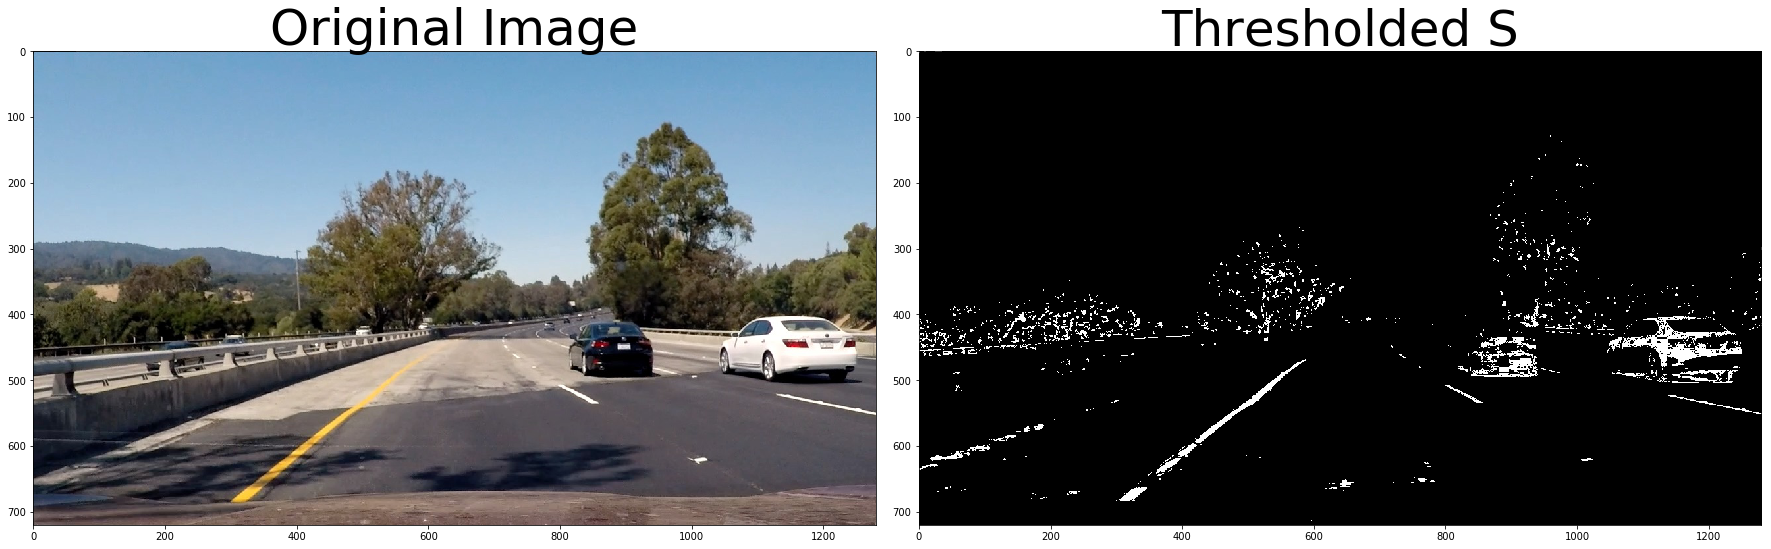

In [56]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/test4.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255), h_thresh=(15,100)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    S=hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
    
hls_binary = hls_select(image, thresh=(170, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Combined Threshold

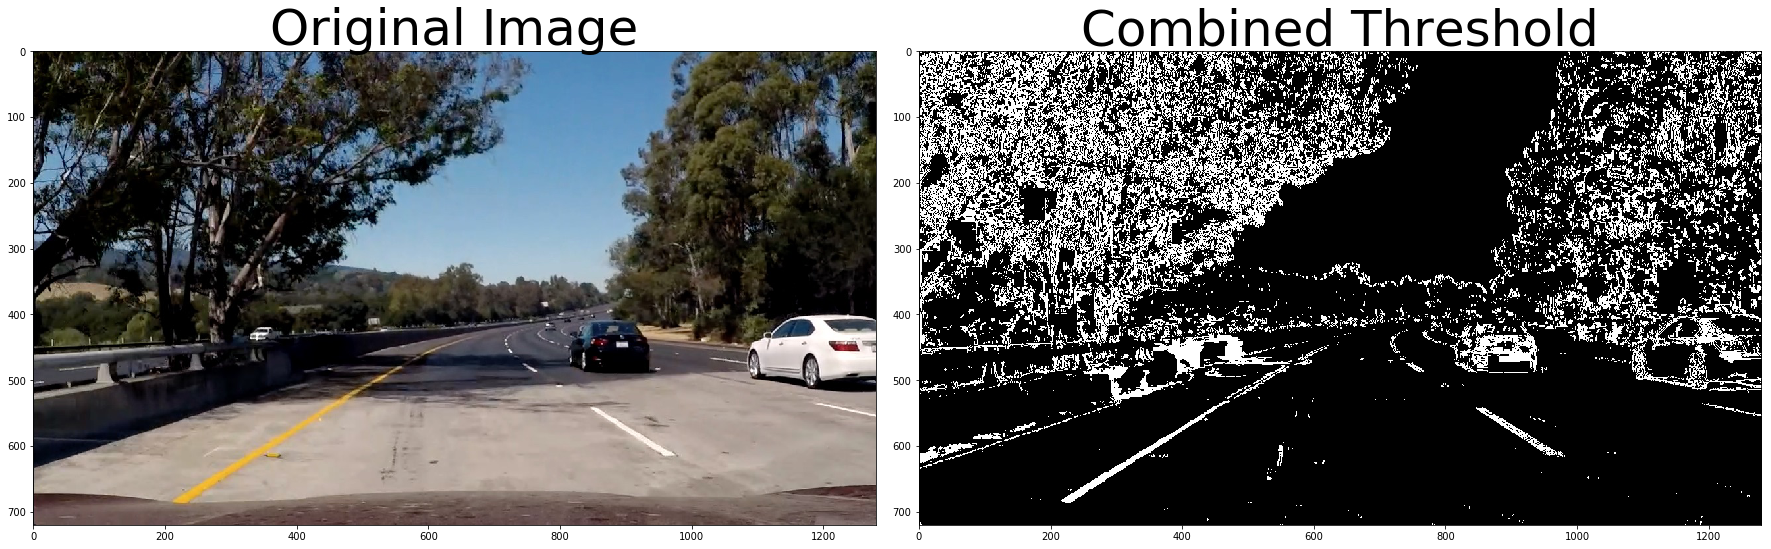

In [60]:
def combined_thresh(image):
   
    grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    
    hls_binary = hls_select(image, thresh=(170, 255))
    combined = np.zeros_like(hls_binary)
    combined[(hls_binary == 1) | (grad_binary == 1)] = 1
    return combined

image = cv2.imread('test_images/test5.jpg') 
combined=combined_thresh(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Perspective Transform

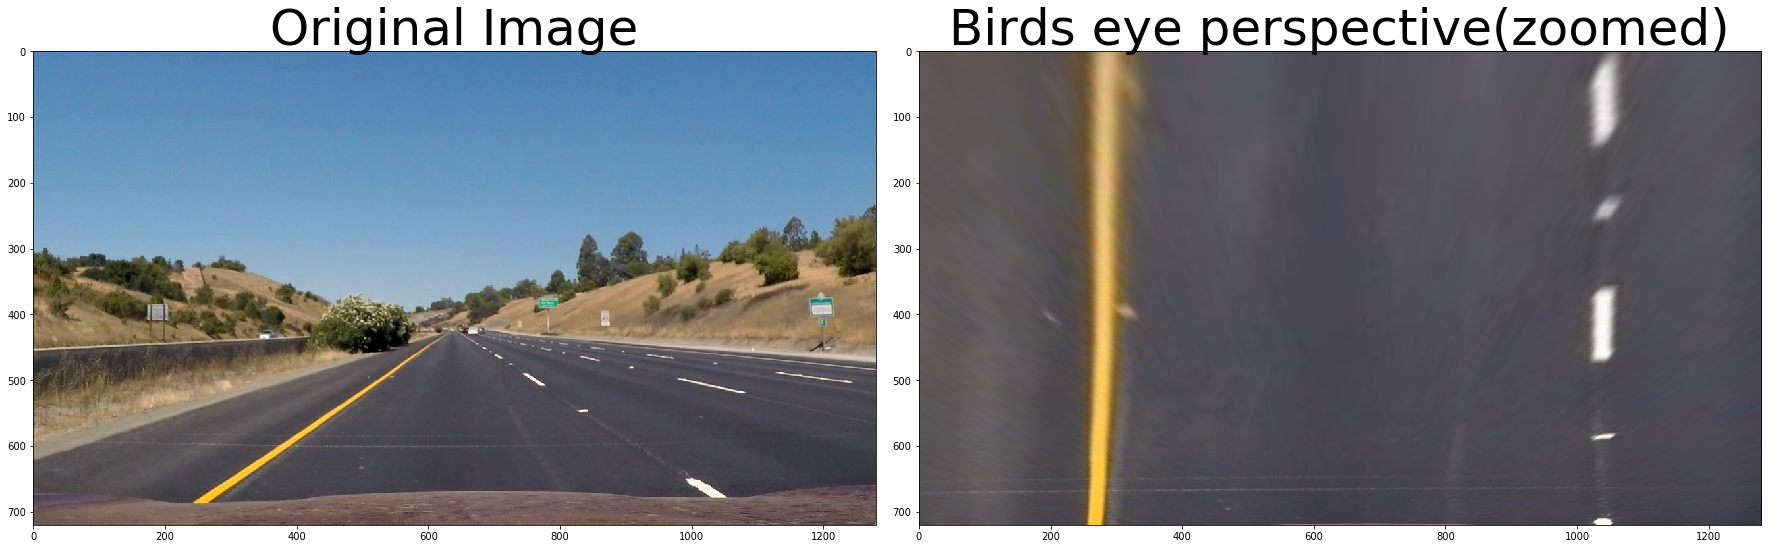

In [8]:
def warp_perspective(img, src):
    offset=10 # to shift the board  up so that only the interested portion is shown
    img_shape = (img.shape[1], img.shape[0])

    lx=src[3][0]
    ly=offset
    rx=src[2][0]
    ry=ly
    brx=rx
    bry=img_shape[1]
    blx=lx
    bly=bry
    dst = np.float32([[lx,ly],[rx,ry],[brx,bry],[blx,bly]])
    #print('dst:', dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR) 
    return warped

img = cv2.imread('test_images/straight_lines1.jpg')
src=np.float32([[578, 460], [700,460], [1036, 678], [261, 678]])
#print('src:', src)
udis = undistort(img)
mywarped = warp_perspective(udis, src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
mywarped = cv2.cvtColor(mywarped, cv2.COLOR_BGR2RGB)
ax2.imshow(mywarped)
ax2.set_title('Birds eye perspective(zoomed)', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### Identifying lane line pixels and fitting with a polynomial

#### sliding windows and polynomial fitting

In [9]:
def poly_fit_lane_lines(binary_warped):
    #print('debug:', binary_warped)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds, left_fit, right_fit

#### Visualize the sliding window and polyfit

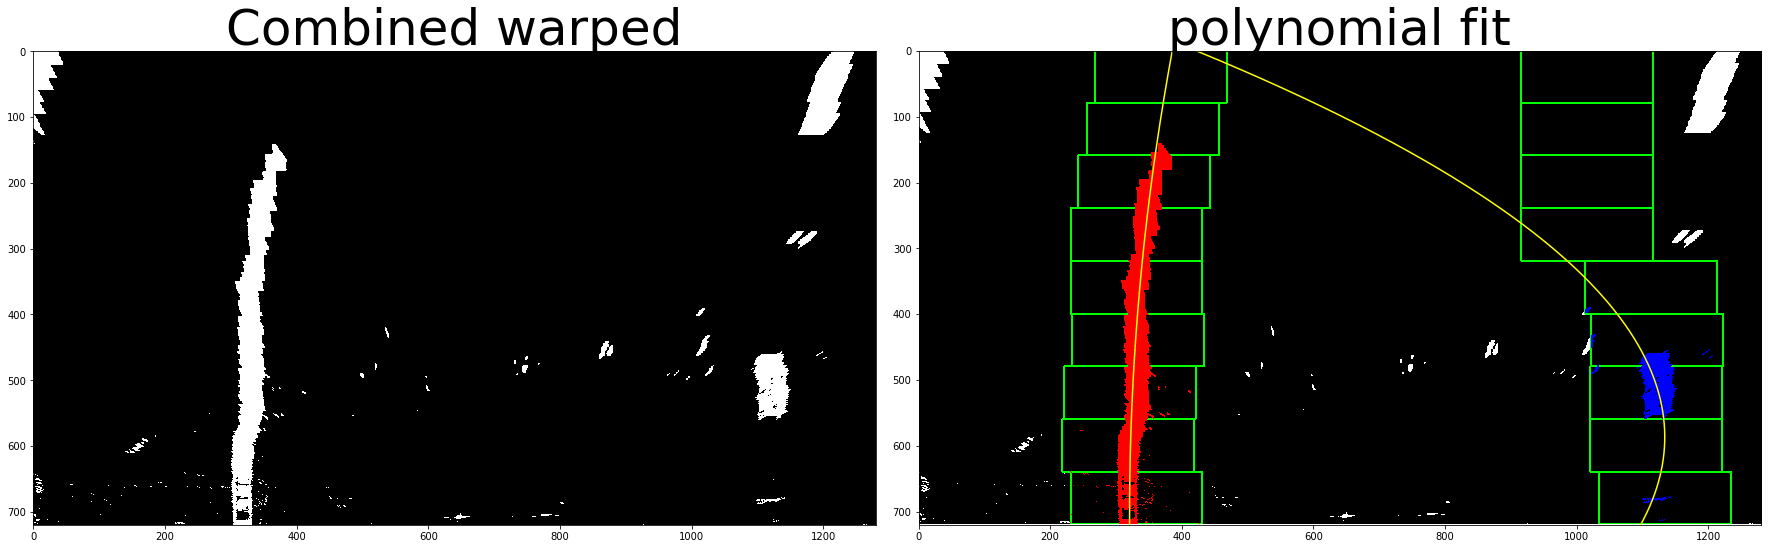

In [69]:
img2 = cv2.imread('test_images/test4.jpg')
combined_bin = combined_thresh(img2)
binary_warped=warp_perspective(combined_bin, src)

out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds, left_fit, right_fit = poly_fit_lane_lines(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Combined warped', fontsize=50)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
ax2.set_title('polynomial fit', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()